In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [3]:
train_df = pd.read_csv("./fhs_train.csv", low_memory=False)
train_df = train_df.drop("Unnamed: 0", axis=1)
display(train_df.head())
print(train_df.isna().sum())

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,58,1.0,0,0.0,0.0,0,0,0,220.0,143.0,104.0,29.85,75,87.0,1
1,0,40,1.0,1,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85,77.0,0
2,0,52,1.0,0,0.0,0.0,0,0,0,275.0,112.0,71.0,25.68,80,NaN,0
3,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110,75.0,0
4,0,43,1.0,0,0.0,0.0,0,0,0,202.0,124.0,92.0,21.26,75,74.0,0


sex                  0
age                  0
education           85
currentSmoker        0
cigsPerDay          24
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             39
sysBP                0
diaBP                0
BMI                 15
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64


In [4]:
train_df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3180.000000,3180.000000,3095.000000,3180.000000,3156.000000,3143.000000,3180.000000,3180.000000,3180.000000,3141.000000,3180.000000,3180.000000,3165.000000,3180.000000,2895.000000,3180.000000
mean,0.433019,49.633962,1.957027,0.490881,8.970532,0.029590,0.006604,0.321069,0.026101,236.600764,132.784748,83.117767,25.888117,75.942138,81.833506,0.153145
std,0.495571,8.557596,1.011135,0.499995,12.013704,0.169479,0.081008,0.466961,0.159460,44.847411,22.433267,12.009212,4.130475,12.050504,23.625357,0.360184
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,50.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,117.000000,75.000000,23.100000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.000000,129.000000,82.000000,25.490000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.125000,90.000000,28.140000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,140.000000,394.000000,1.000000


In [5]:
print(train_df.shape)
print(train_df["TenYearCHD"].value_counts()) # 15.31% have chd
drop_train_df = train_df.dropna()
print(drop_train_df.shape) # 86.29% of train_df
print(drop_train_df["TenYearCHD"].value_counts()) # 15.45% have chd
na_train_df = train_df[train_df.isna().any(axis=1)]
print(na_train_df.shape) # 13.71% of train_df
print(na_train_df["TenYearCHD"].value_counts()) # 14.45% have chd

# for now choose to drop na values

(3180, 16)
TenYearCHD
0    2693
1     487
Name: count, dtype: int64
(2744, 16)
TenYearCHD
0    2320
1     424
Name: count, dtype: int64
(436, 16)
TenYearCHD
0    373
1     63
Name: count, dtype: int64


In [6]:
test_df = pd.read_csv("./fhs_test.csv", low_memory=False)
test_df = test_df.drop("Unnamed: 0", axis=1)
display(test_df.head())
print(test_df.isna().sum())

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,58,1.0,1,20.0,0.0,0,0,0,NaN,126.0,77.0,30.08,78.0,NaN,0
1,0,51,3.0,0,0.0,0.0,0,0,0,264.0,135.0,83.0,26.68,60.0,74.0,0
2,0,44,2.0,1,9.0,0.0,0,1,0,NaN,147.5,96.0,30.57,78.0,NaN,1
3,0,40,2.0,1,20.0,0.0,0,0,0,271.0,138.5,88.0,27.24,80.0,NaN,1
4,1,58,2.0,1,20.0,0.0,0,0,0,207.0,110.0,80.0,23.55,78.0,78.0,0


sex                  0
age                  0
education           20
currentSmoker        0
cigsPerDay           5
BPMeds              16
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             11
sysBP                0
diaBP                0
BMI                  4
heartRate            1
glucose            103
TenYearCHD           0
dtype: int64


do we need to clean missing values for education, cigsPerDay, BPMeds, totChol, BMI, and glucose?

In [7]:
test_df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,1060.000000,1060.000000,1040.000000,1060.000000,1055.000000,1044.000000,1060.000000,1060.000000,1060.000000,1049.000000,1060.000000,1060.000000,1056.000000,1059.000000,957.000000,1060.000000
mean,0.417925,49.418868,2.046154,0.503774,9.111848,0.029693,0.003774,0.279245,0.024528,236.995234,131.064151,82.237736,25.539100,75.689330,82.357367,0.148113
std,0.493450,8.620858,1.042774,0.500222,11.650215,0.169822,0.061342,0.448840,0.154755,43.835233,20.743991,11.589415,3.914418,11.953153,24.931659,0.355380
min,0.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.000000,92.500000,48.000000,15.960000,45.000000,44.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.000000,22.850000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,235.000000,127.000000,81.000000,25.140000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,265.000000,140.125000,88.000000,27.860000,82.000000,87.000000,0.000000
max,1.000000,69.000000,4.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,453.000000,215.000000,140.000000,45.790000,143.000000,394.000000,1.000000


***Cleaning***

In [8]:
from sklearn.impute import SimpleImputer

#cleaning cholesterol (note needed two imputers for each variable or else an error occures)
imputer_totChol = SimpleImputer(strategy='mean')

#imputing median values for totChol missing values
train_df['totChol'] = imputer_totChol.fit_transform(train_df[['totChol']])
test_df['totChol'] = imputer_totChol.transform(test_df[['totChol']])

#cleaning glucose
imputer = SimpleImputer(strategy='mean')

#glucose has high correlation with diabetes so split diabetes into two groups and impute based on median values of both groups respectively
diabetic_train = train_df[train_df['diabetes'] == 1]
non_diabetic_train = train_df[train_df['diabetes'] == 0]
diabetic_test = test_df[test_df['diabetes'] == 1]
non_diabetic_test = test_df[test_df['diabetes'] == 0]

diabetic_train['glucose'] = imputer.fit_transform(diabetic_train[['glucose']])
non_diabetic_train['glucose'] = imputer.transform(non_diabetic_train[['glucose']])
diabetic_test['glucose'] = imputer.fit_transform(diabetic_test[['glucose']])
non_diabetic_test['glucose'] = imputer.transform(non_diabetic_test[['glucose']])

#combine glucose groups back togerther
train_df = pd.concat([diabetic_train, non_diabetic_train], axis=0).sort_index()
test_df = pd.concat([diabetic_test, non_diabetic_test], axis=0).sort_index()

#drop remaining values
drop_train_df = train_df.dropna()
drop_test_df = test_df.dropna()

#check dataset dimenstions and any missing values
print("New train_df shape:", drop_train_df.shape)
print("New test_df shape:", drop_test_df.shape)
print(drop_train_df.isna().sum())
print(drop_test_df.isna().sum())





New train_df shape: (3022, 16)
New test_df shape: (1014, 16)
sex                0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64
sex                0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


C:\Users\rdinh\AppData\Local\Temp\ipykernel_36116\2411129685.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic_train['glucose'] = imputer.fit_transform(diabetic_train[['glucose']])
C:\Users\rdinh\AppData\Local\Temp\ipykernel_36116\2411129685.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_diabetic_train['glucose'] = imputer.transform(non_diabetic_train[['glucose']])
C:\Users\rdinh\AppData\Local\Temp\ipykernel_36116\2411129685.py:21: SettingWithCopyWarning: 
A value is trying to be set o

In [9]:
#So need to clean totchol and glucose
#since totchol doesnt have high correlation with other variables I think its fine to just impute median or mean on the 11 missing values

#glucose has high correlation with diabetes so maybe we can split glucose into two groups of having diabetes(1) and not having diabteses(0) and then impute median or mean on the two seperate groups.



In [10]:
display(drop_train_df.corr())
display(drop_test_df.corr())
# let's pick out correlations with an absolute value greater than 0.5:
    # currentSmoker and cigsPerDay are correlated
    # prevalentHyp and sysBP and diaBP are correlated
    # diabetes and glucose are correlated

# glucose has the most missing values and it is correlated with diabetes, so droping these values might have an impact on our final models
# cigsPerDay also has a few missing values but not as many as glucose, could also impact final models

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
sex,1.000000,-0.032232,-0.000488,0.198416,0.327519,-0.044171,0.009969,0.012791,0.020963,-0.075324,-0.025609,0.064120,0.082255,-0.114848,-0.061178,0.100951
age,-0.032232,1.000000,-0.171271,-0.217282,-0.199996,0.118593,0.047956,0.295923,0.089087,0.269074,0.393667,0.210876,0.139995,-0.015212,0.055219,0.226033
education,-0.000488,-0.171271,1.000000,0.012622,0.003196,-0.013795,-0.022273,-0.078305,-0.038571,-0.025359,-0.135416,-0.066147,-0.148850,-0.077797,-0.017150,-0.051570
currentSmoker,0.198416,-0.217282,0.012622,1.000000,0.766890,-0.051154,-0.032924,-0.101649,-0.030271,-0.027869,-0.135515,-0.107722,-0.175284,0.055347,-0.027925,0.008113
cigsPerDay,0.327519,-0.199996,0.003196,0.766890,1.000000,-0.047489,-0.031779,-0.069346,-0.029813,-0.015219,-0.092817,-0.050363,-0.092477,0.075023,-0.041892,0.050435
BPMeds,-0.044171,0.118593,-0.013795,-0.051154,-0.047489,1.000000,0.138233,0.254825,0.045141,0.077654,0.256796,0.202971,0.091383,-0.002774,0.014752,0.094243
prevalentStroke,0.009969,0.047956,-0.022273,-0.032924,-0.031779,0.138233,1.000000,0.057318,-0.012600,0.000014,0.052846,0.042679,0.010664,-0.017883,-0.006720,0.039240
prevalentHyp,0.012791,0.295923,-0.078305,-0.101649,-0.069346,0.254825,0.057318,1.000000,0.075827,0.164897,0.688676,0.616369,0.302439,0.151570,0.049313,0.162068
diabetes,0.020963,0.089087,-0.038571,-0.030271,-0.029813,0.045141,-0.012600,0.075827,1.000000,0.048515,0.090136,0.042682,0.081394,0.042880,0.377194,0.099972
totChol,-0.075324,0.269074,-0.025359,-0.027869,-0.015219,0.077654,0.000014,0.164897,0.048515,1.000000,0.212963,0.154398,0.119596,0.077907,0.010970,0.100307


,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
sex,1.000000,-0.001665,0.060865,0.192475,0.298043,-0.074637,-0.052489,-0.012879,0.002029,-0.046734,-0.065395,0.039079,0.068129,-0.127168,-0.058466,0.057695
age,-0.001665,1.000000,-0.136351,-0.199388,-0.162629,0.146482,0.032628,0.330760,0.139692,0.265452,0.386319,0.197393,0.119990,0.003941,0.061252,0.217709
education,0.060865,-0.136351,1.000000,0.034035,0.023568,-0.003004,-0.048342,-0.079001,-0.020093,-0.017801,-0.101287,-0.051556,-0.095259,0.003426,-0.022540,-0.057864
currentSmoker,0.192475,-0.199388,0.034035,1.000000,0.781112,-0.034922,-0.031466,-0.114703,-0.064875,-0.110822,-0.112551,-0.114572,-0.132099,0.056338,0.014784,0.061800
cigsPerDay,0.298043,-0.162629,0.023568,0.781112,1.000000,-0.039890,-0.042399,-0.064419,-0.050841,-0.060215,-0.079078,-0.069743,-0.073665,0.053516,0.020102,0.077574
BPMeds,-0.074637,0.146482,-0.003004,-0.034922,-0.039890,1.000000,0.081863,0.282704,0.049389,0.107496,0.268811,0.173110,0.133886,0.078228,0.058384,0.077595
prevalentStroke,-0.052489,0.032628,-0.048342,-0.031466,-0.042399,0.081863,1.000000,0.101892,0.093698,0.037831,0.060470,0.071060,0.108541,0.007903,0.028017,0.063818
prevalentHyp,-0.012879,0.330760,-0.079001,-0.114703,-0.064419,0.282704,0.101892,1.000000,0.063452,0.163263,0.715665,0.618412,0.298961,0.147159,0.045681,0.217926
diabetes,0.002029,0.139692,-0.020093,-0.064875,-0.050841,0.049389,0.093698,0.063452,1.000000,0.031514,0.125422,0.065228,0.074339,0.066417,0.374855,0.065497
totChol,-0.046734,0.265452,-0.017801,-0.110822,-0.060215,0.107496,0.037831,0.163263,0.031514,1.000000,0.216153,0.220753,0.133030,0.118310,0.036547,0.026328


In [11]:
xtrain = drop_train_df.drop("TenYearCHD", axis=1)
xtest = drop_test_df.drop("TenYearCHD", axis=1)
ytrain = drop_train_df["TenYearCHD"]
ytest = drop_test_df["TenYearCHD"]
print(ytrain.describe())
print(ytest.describe())

ntest = len(ytest)
tss = np.sum((ytest - ytrain.mean()) ** 2)

count    3022.000000
mean        0.151555
std         0.358649
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TenYearCHD, dtype: float64
count    1014.000000
mean        0.143984
std         0.351247
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TenYearCHD, dtype: float64


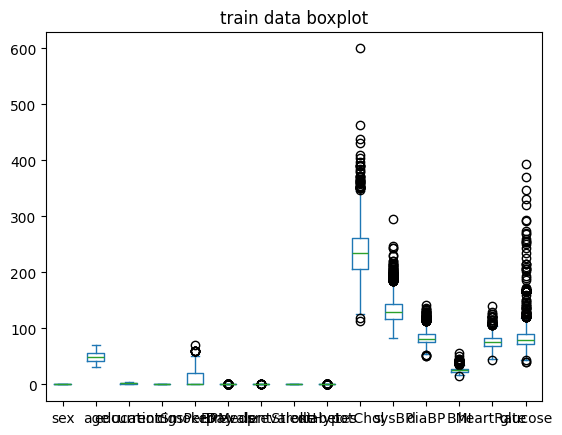

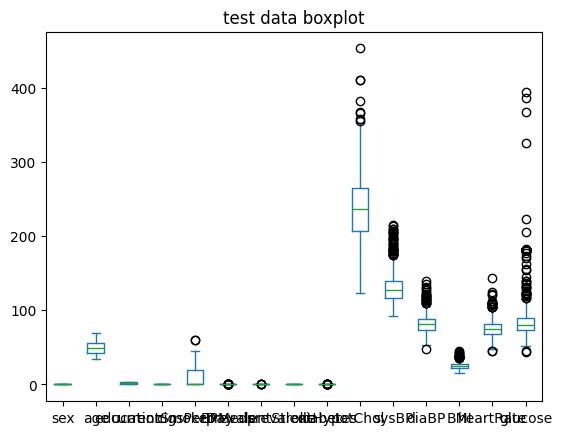

In [12]:
xtrain.plot.box()
plt.title("train data boxplot")
plt.show()
xtest.plot.box()
plt.title("test data boxplot")
plt.show()
# only sex, age, education, currentsmoker, and prevalenthyp do not have outliers

In [13]:
%%capture --no-display
%%script echo skipping

# can redefine train and test based on the variables that the tree chose because those seem the most predictive:
select_drop_train_df = drop_train_df[["sex", "age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "glucose", "TenYearCHD"]]
select_drop_test_df = drop_test_df[["sex", "age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "glucose", "TenYearCHD"]]
xtrain = select_drop_train_df.drop("TenYearCHD", axis=1)
ytrain = select_drop_train_df["TenYearCHD"]
xtest = select_drop_test_df.drop("TenYearCHD", axis=1)
ytest = select_drop_test_df["TenYearCHD"]


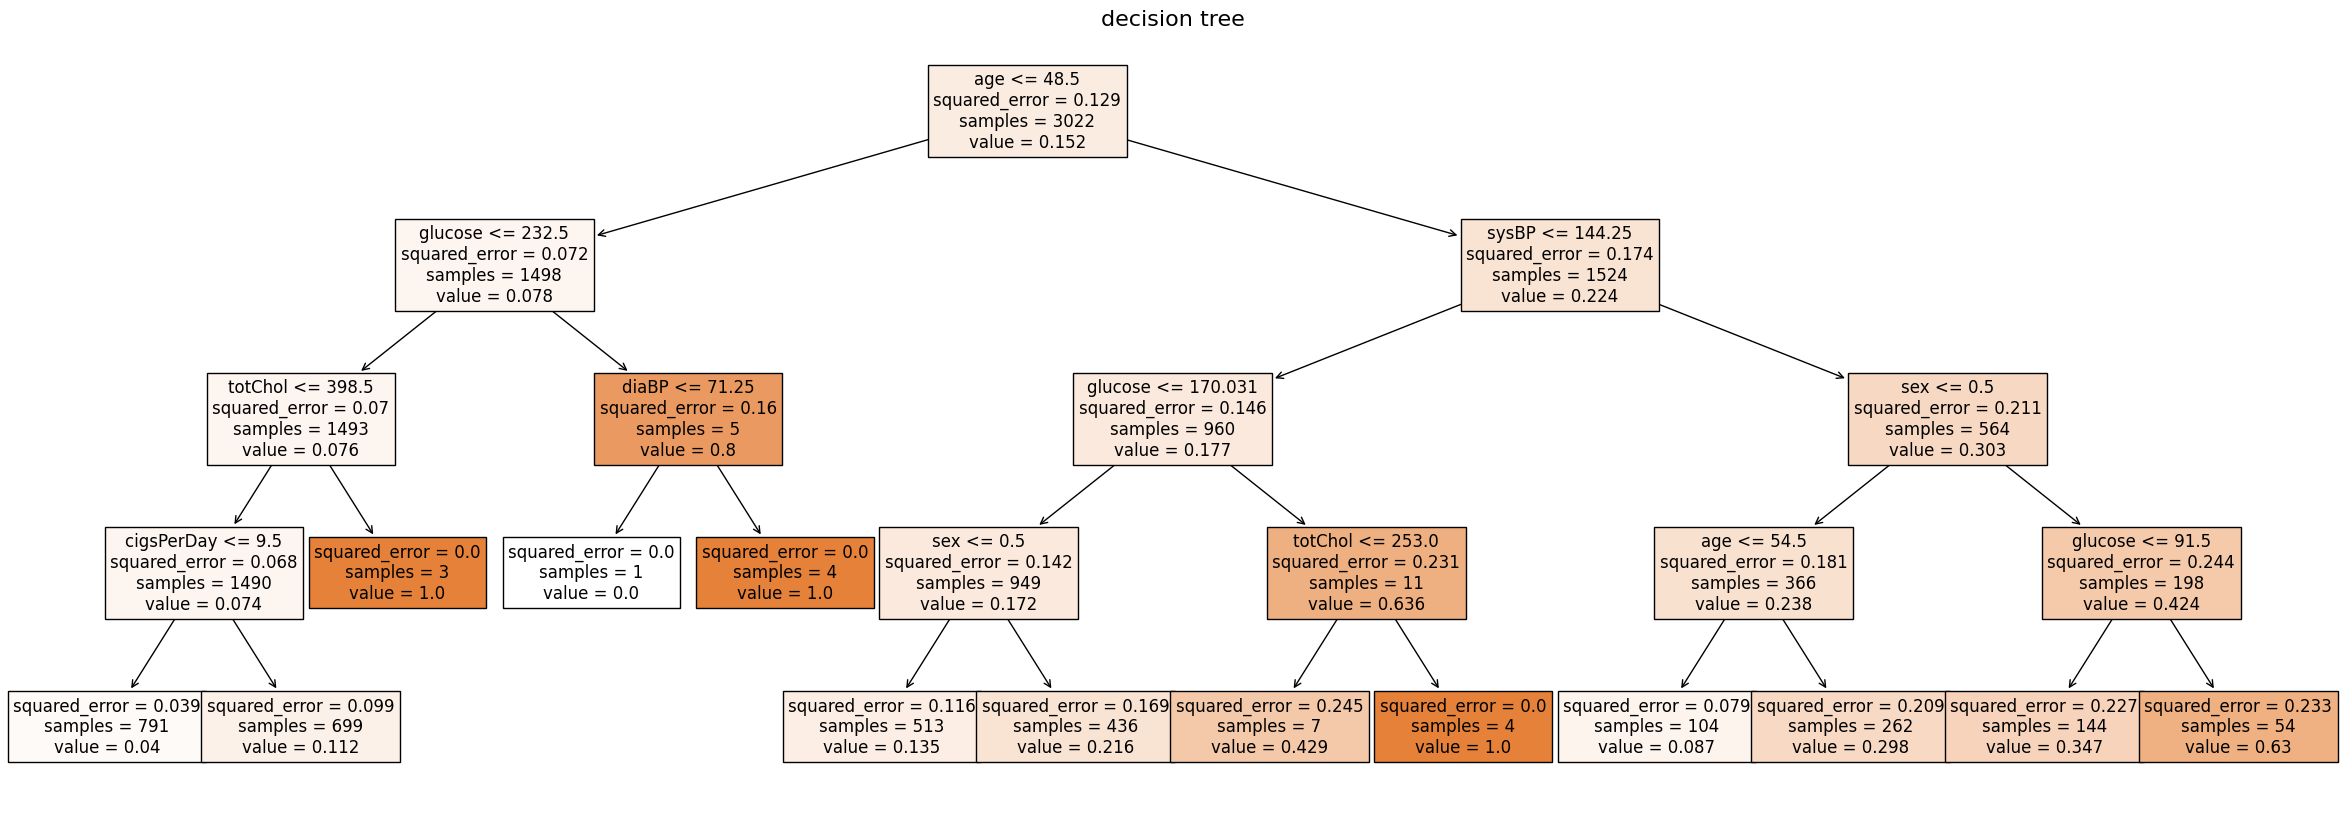

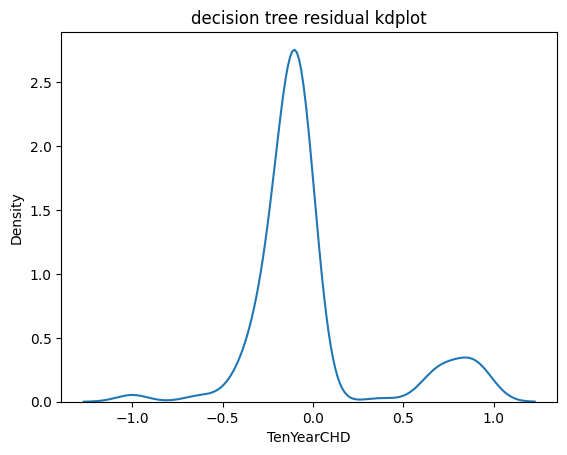

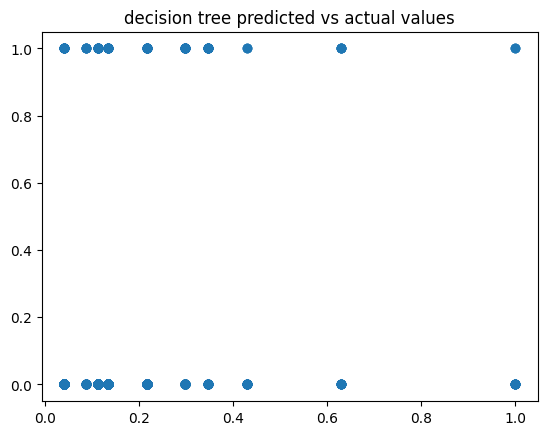

In [14]:
# tree approach:

cart = DecisionTreeRegressor(max_depth=4).fit(xtrain, ytrain)
varnames = list(cart.feature_names_in_)

#adjusting the tree plot size so its easier to see
plt.figure(figsize=(30, 10)) #adjust these nums
plot_tree(cart, filled=True, feature_names=varnames, fontsize=12) 
plt.title("decision tree", fontsize=16)
plt.savefig("./tree.png", dpi=500)  
plt.show()

yhat_tree = cart.predict(xtest)
residual = ytest - yhat_tree
sns.kdeplot(residual).set_title("decision tree residual kdplot")
plt.show()

plt.scatter(x=yhat_tree, y=ytest)
plt.title("decision tree predicted vs actual values")
plt.show()

sse_tree = np.sum((ytest - yhat_tree) ** 2)
mse_tree = sse_tree / ntest
rmse_tree = np.sqrt(sse_tree / ntest)
r2_tree = 1 - sse_tree / tss

Based on the decision tree:
- age was the variable influencing the primary split in the tree so it is a signficant risk factor for predicting the chances of someone getting CHD.
- tolchol and sysBP are the next highest risk factors based on the splits, which makes sense because cholesterol levels and blood pressure levels used as indicators for heart health.
- interesting note cigsperday is a splitter in both age groups but the prediction of CHD factors differently for the two.

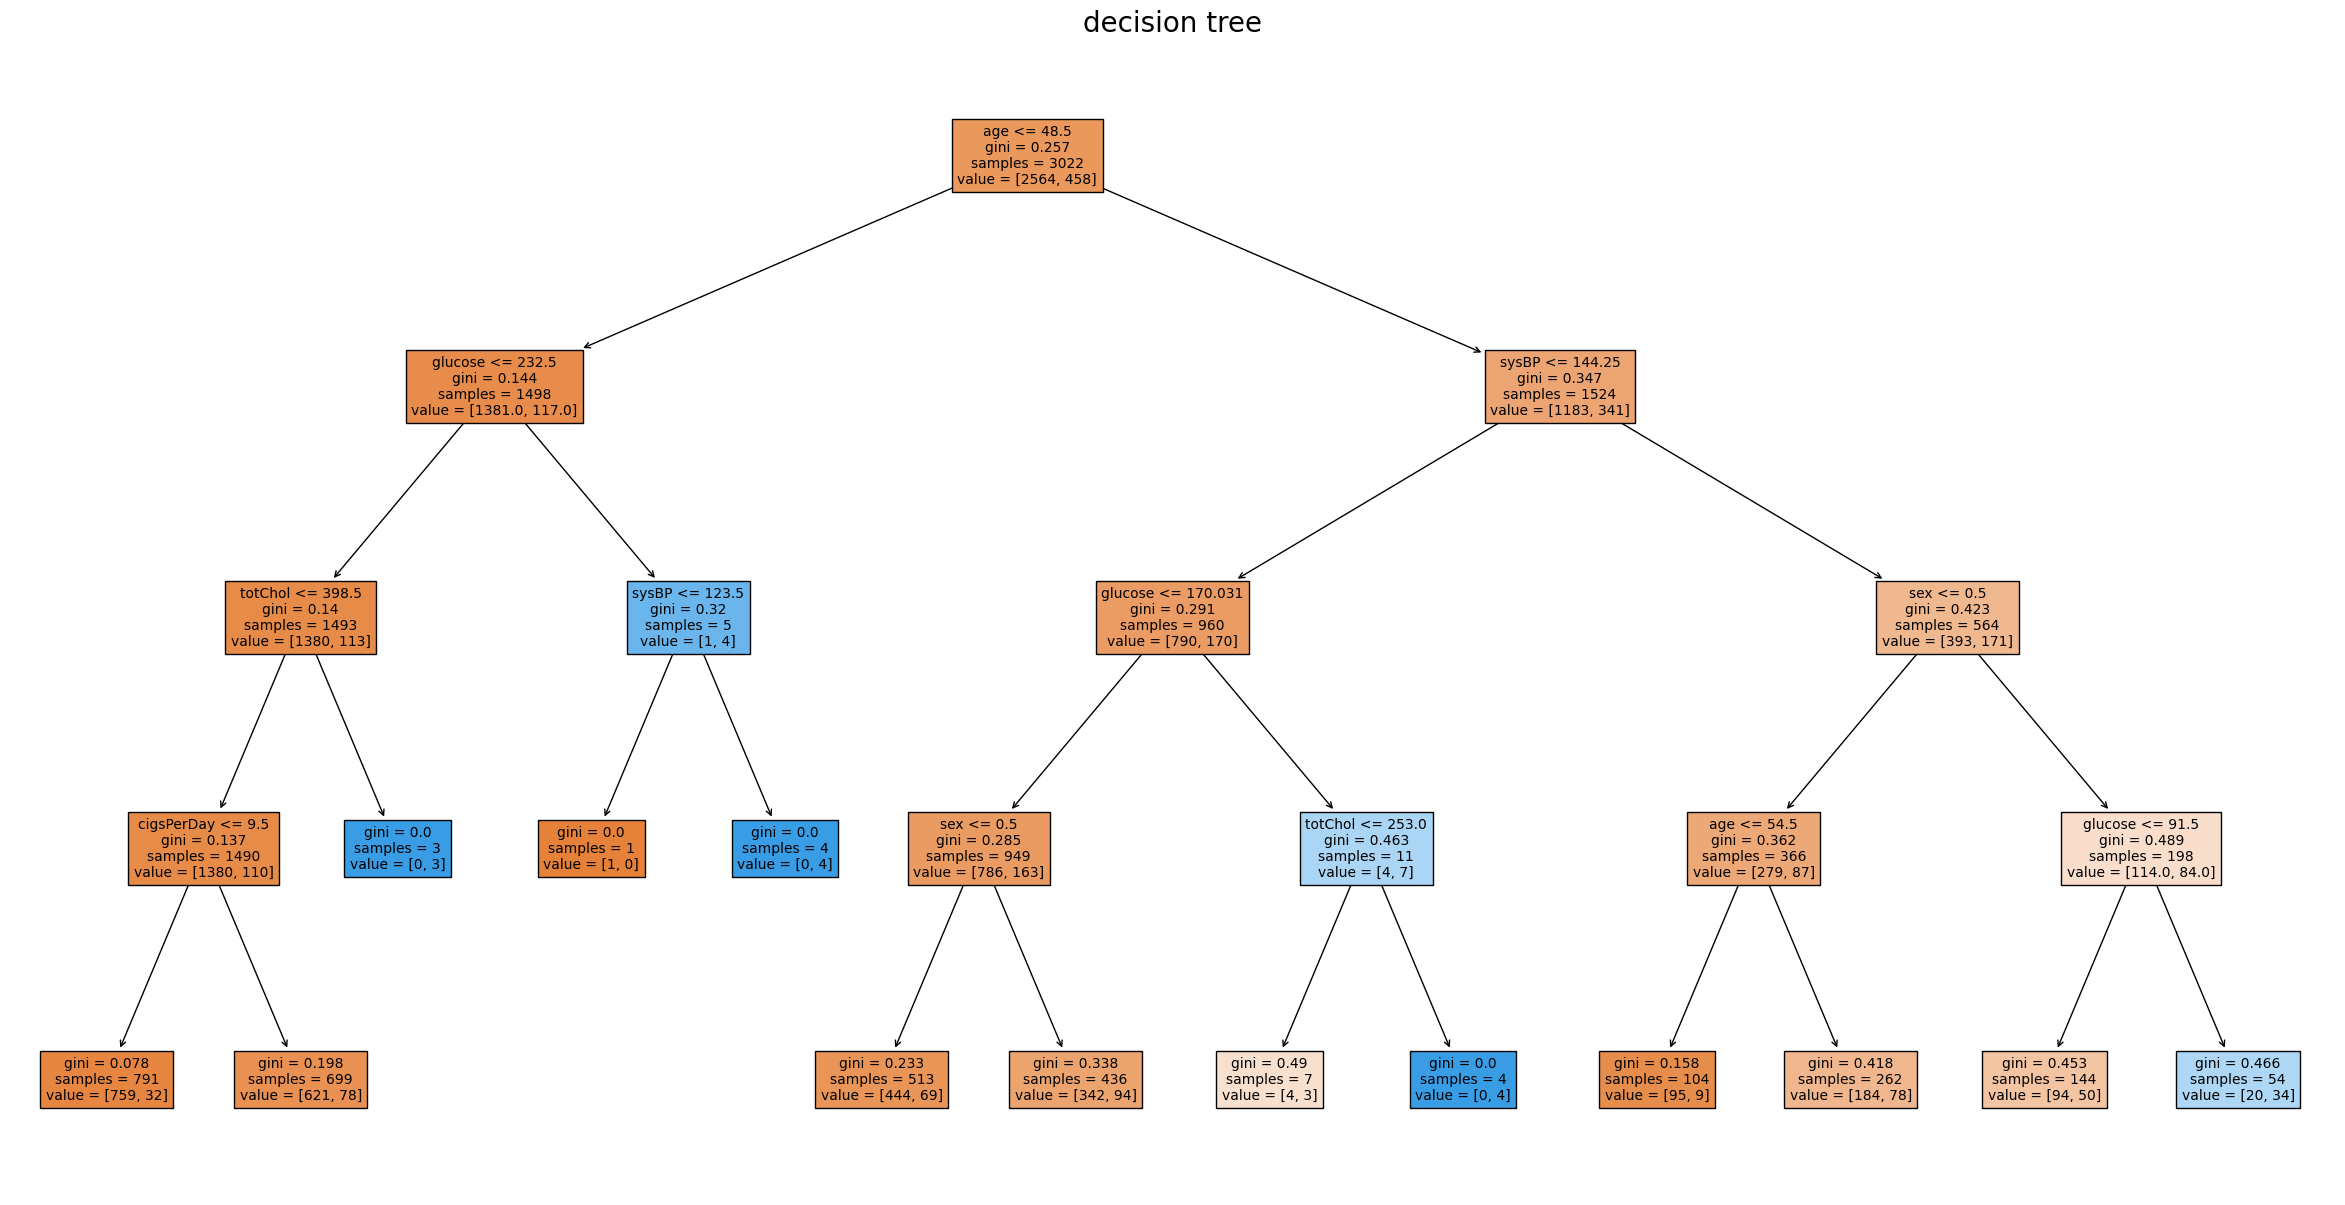

Accuracy of Decision Tree Classifier: 0.8431952662721893
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       868
           1       0.29      0.06      0.10       146

    accuracy                           0.84      1014
   macro avg       0.58      0.52      0.51      1014
weighted avg       0.78      0.84      0.80      1014

Confusion Matrix:
 [[846  22]
 [137   9]]


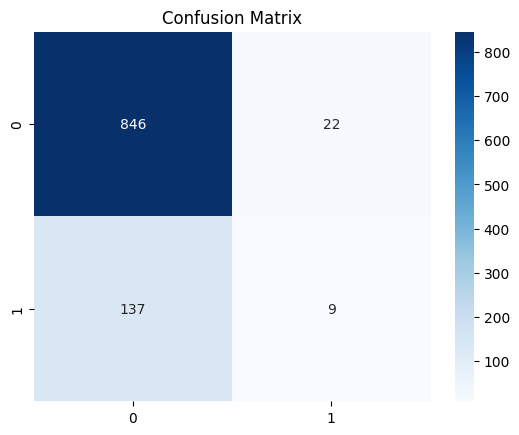

In [15]:
#decision tree but using classifier instead of regressor and confusion matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

cart = DecisionTreeClassifier(max_depth=4).fit(xtrain, ytrain)
varnames = list(xtrain.columns)  # Make sure xtrain is a DataFrame to use this line


plt.figure(figsize=(30, 15))#increase figure size
plot_tree(cart, filled=True, feature_names=varnames, fontsize=10)
plt.title("decision tree", fontsize=20)
plt.savefig("./tree_classifier.png", dpi=500) 
plt.show()

#accuracy and report
yhat_tree = cart.predict(xtest)
accuracy_tree = accuracy_score(ytest, yhat_tree)
report_tree = classification_report(ytest, yhat_tree)

#confusion matrix to analyze error
conf_matrix_tree = confusion_matrix(ytest, yhat_tree)

print("Accuracy of Decision Tree Classifier:", accuracy_tree)
print("Classification Report:\n", report_tree)
print("Confusion Matrix:\n", conf_matrix_tree)

#confusion matrix
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Notes:
- lower gini is better as the tree node indicates that the gini value of samples in the node belong to that singular class
- for 10year CHD the matrix shows
    - model performs well in predicting the negative class (0), but it performs poorly in predicting the positive class (1). 
    - high accuracy and F1-score for class 0, but very low recall and F1-score for class 1
    - model very rarely predicts CHD (True Positives are low), and for the ones it does predict it is mostly wrong (False negatives are high relative to True positves)
        - is this because of class imbalance?

minimum SSE: 117.54907792980369; optimal k: 41


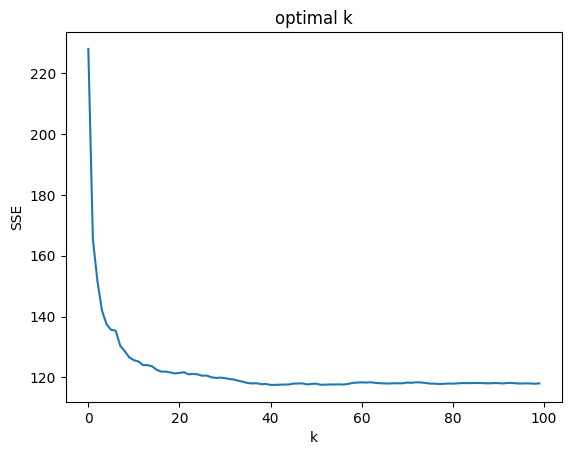

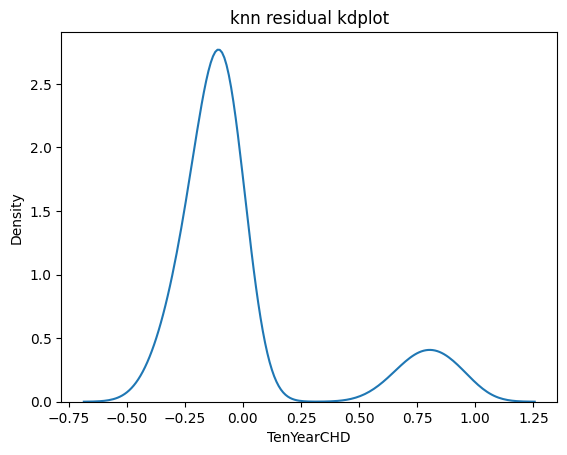

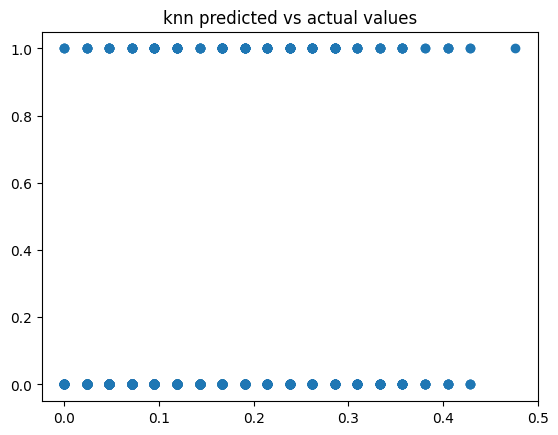

In [16]:
# kNN approach:
def maxmin(x):
    return (x - min(x)) / (max(x) - min(x))

xtrain_knn = xtrain.apply(maxmin)
xtest_knn = xtest.apply(maxmin)

karr = np.arange(1, 101)
sse = np.zeros(100)
ssemin = np.min(sse)
for k in range(100):
    model = KNeighborsRegressor(n_neighbors=k + 1).fit(xtrain_knn, ytrain)
    yhat = model.predict(xtest_knn)
    sse[k] = np.sum((ytest - yhat) ** 2)

ssemin = np.min(sse)
index = np.where(sse == ssemin)[0]
opt = karr[index]
print(f"minimum SSE: {ssemin}; optimal k:", end=" ")
print(*opt, sep=", ")
plt.plot(np.arange(100), sse)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("optimal k")
plt.show()

model = KNeighborsRegressor(n_neighbors=opt[0] + 1).fit(xtrain_knn, ytrain)
yhat_knn = model.predict(xtest_knn)
residual = ytest - yhat_knn
sns.kdeplot(residual).set_title("knn residual kdplot")
plt.show()

plt.scatter(x=yhat_knn, y=ytest)
plt.title("knn predicted vs actual values")
plt.show()

sse_knn = np.sum((ytest - yhat_knn) ** 2)
mse_knn = sse_knn / ntest
rmse_knn = np.sqrt(sse_knn / ntest)
r2_knn = 1 - sse_knn / tss

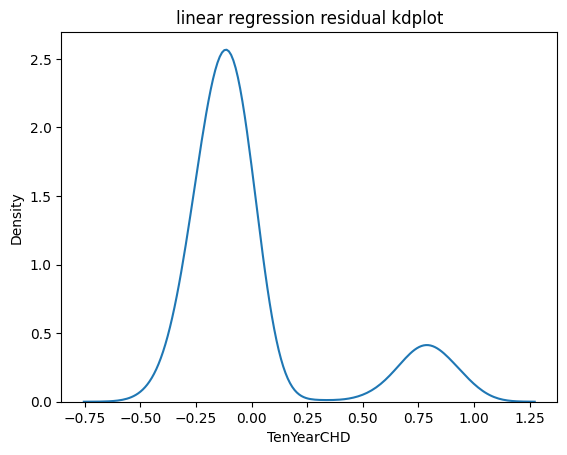

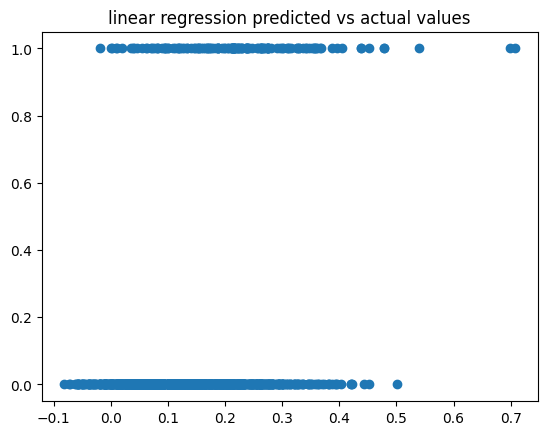

In [17]:
# linear regression approach:
reg = LinearRegression().fit(xtrain, ytrain)
yhat_lr = reg.predict(xtest)
residual = ytest - yhat_lr
sns.kdeplot(residual).set_title("linear regression residual kdplot")
plt.show()

plt.scatter(x=yhat_lr, y=ytest)
plt.title("linear regression predicted vs actual values")
plt.show()

sse_lr = np.sum((ytest - yhat_lr) ** 2)
mse_lr = sse_lr / ntest
rmse_lr = np.sqrt(sse_lr / ntest)
r2_lr = 1 - sse_lr / tss

In [18]:
# comparison table:

cdf = pd.DataFrame({"SSE": [sse_tree, sse_knn, sse_lr], "MSE": [mse_tree, mse_knn, mse_lr], "RMSE": [rmse_tree, rmse_knn, rmse_lr], "R2": [r2_tree, r2_knn, r2_lr]})
cdf.index = ['TREE', 'kNN', 'LR']
cdf.head()

# analyze why these models did so poorly, professor suggests looking at https://en.wikipedia.org/wiki/Coronary_artery_disease to find out if the variables we have are actually strong predictors or not
# could also be different if we imputed values, analyze why some of the non-response is correlated (there is a section in the background pdf on non-response bias)
# could be improved if we only regressed on the variables that the tree chose
# maybe it's just a really far fetched idea to be able to predict CHD ten years later - a lot can change in ten years

,SSE,MSE,RMSE,R2
TREE,129.652016,0.127862,0.357578,-0.036914
kNN,117.576531,0.115953,0.340519,0.059662
LR,114.794026,0.113209,0.336466,0.081915
